In [100]:
% matplotlib inline

import numpy as np
import pandas as pd
import pydotplus

from matplotlib import pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier

* Get the diamonds data from ggplot2's diamonds dataset from R to a csv file:

R code
> require(ggplot2)

> data(diamonds)

> write.table(diamonds, file='diamonds.csv', sep=',', quote=FALSE, row.names=FALSE)`

## Diamonds dataset

### Format
A data frame with 53940 rows and 10 variables

### Description
A dataset containing the prices and other attributes of almost 54,000 diamonds. The variables are as follows:

### Details
- __price__: price in US dollars (\$326--\$18,823)
- __carat__: weight of the diamond (0.2--5.01)
- __cut__: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- __colour__: diamond colour, from J (worst) to D (best)
- __clarity__: a measurement of how clear the diamond is (I1 (worst), SI1, SI2, VS1, VS2, VVS1, VVS2, IF (best))
- __x__: length in mm (0--10.74)
- __y__: width in mm (0--58.9)
- __z__: depth in mm (0--31.8)
- __depth__: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
- __table__: width of top of diamond relative to widest point (43--95)`


In [101]:
dataset_file = 'diamonds.csv'
price_threshold = 12000

diamonds_df = pd.read_csv(dataset_file)
diamonds_df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [102]:
diamonds_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [103]:
features2encode = ['cut', 'color', 'clarity']

label_encodings = {}
for feature in features2encode:
    le = LabelEncoder()
    diamonds_df[feature] = le.fit_transform(diamonds_df[feature])
    print(feature.upper())
    label_encodings[feature] = {}
    for label in le.classes_:
        label_encodings[feature][le.transform(label)] = label
diamonds_df.head()
label_encodings

CUT
COLOR
CLARITY


{'clarity': {0: 'I1',
  1: 'IF',
  2: 'SI1',
  3: 'SI2',
  4: 'VS1',
  5: 'VS2',
  6: 'VVS1',
  7: 'VVS2'},
 'color': {0: 'D', 1: 'E', 2: 'F', 3: 'G', 4: 'H', 5: 'I', 6: 'J'},
 'cut': {0: 'Fair', 1: 'Good', 2: 'Ideal', 3: 'Premium', 4: 'Very Good'}}

In [104]:
diamonds_df.describe()

,carat,cut,color,clarity,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,2.553003,2.594197,3.835150,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.027708,1.701105,1.724591,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,0.000000,0.000000,0.000000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,2.000000,1.000000,2.000000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,2.000000,3.000000,4.000000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,3.000000,4.000000,5.000000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,4.000000,6.000000,7.000000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


* Plot a histogram with a line marking $12,000

R code: `ggplot(diamonds) + geom_histogram(aes(x=price)) + geom_vline(xintercept=12000)`

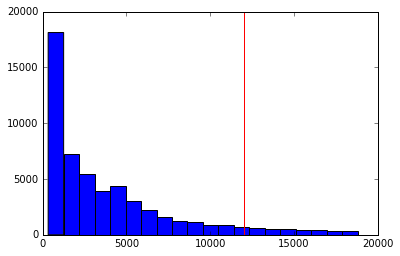

In [105]:
plt.hist(diamonds_df['price'], bins=20)
plt.axvline(price_threshold, color='red')

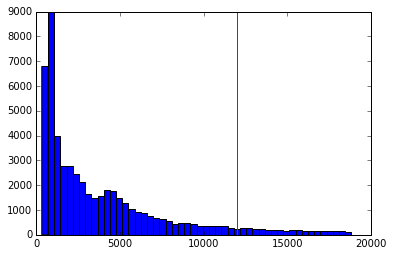

In [106]:
plt.hist(diamonds_df['price'], bins=50)
plt.axvline(12000, color='red')

* Build a TRUE/FALSE variable indicating if the price is above our threshold


In [107]:
diamonds_df['Expensive'] = diamonds_df['price'].apply(lambda x: 1 if x >= price_threshold else 0)
diamonds_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,Expensive
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43,0
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31,0
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31,0
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63,0
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75,0


* get rid of the price column

In [108]:
del diamonds_df['price']

In [109]:
diamonds_df.head()

,carat,cut,color,clarity,depth,table,x,y,z,Expensive
0,0.23,2,1,3,61.5,55.0,3.95,3.98,2.43,0
1,0.21,3,1,2,59.8,61.0,3.89,3.84,2.31,0
2,0.23,1,1,4,56.9,65.0,4.05,4.07,2.31,0
3,0.29,3,5,5,62.4,58.0,4.20,4.23,2.63,0
4,0.31,1,6,3,63.3,58.0,4.34,4.35,2.75,0


In [110]:
target_df = diamonds_df[['Expensive']]
features_df = diamonds_df[['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']]

In [111]:
features_df.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,0.23,2,1,3,61.5,55.0,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,4.34,4.35,2.75


In [112]:
target_df.describe()

,Expensive
count,53940.000000
mean,0.064220
std,0.245146
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [113]:
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df)

## Decision trees

In [114]:
clf = DecisionTreeClassifier(criterion='entropy', random_state=42, max_leaf_nodes=15)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=15, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [115]:
accuracy_score(y_test, clf.predict(X_test))

0.98012606599925844

In [116]:
dot_data = StringIO()  
export_graphviz(clf, out_file=dot_data,  
                         feature_names=features_df.columns,  
                         class_names=['Not expensive', 'Expensive'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())   

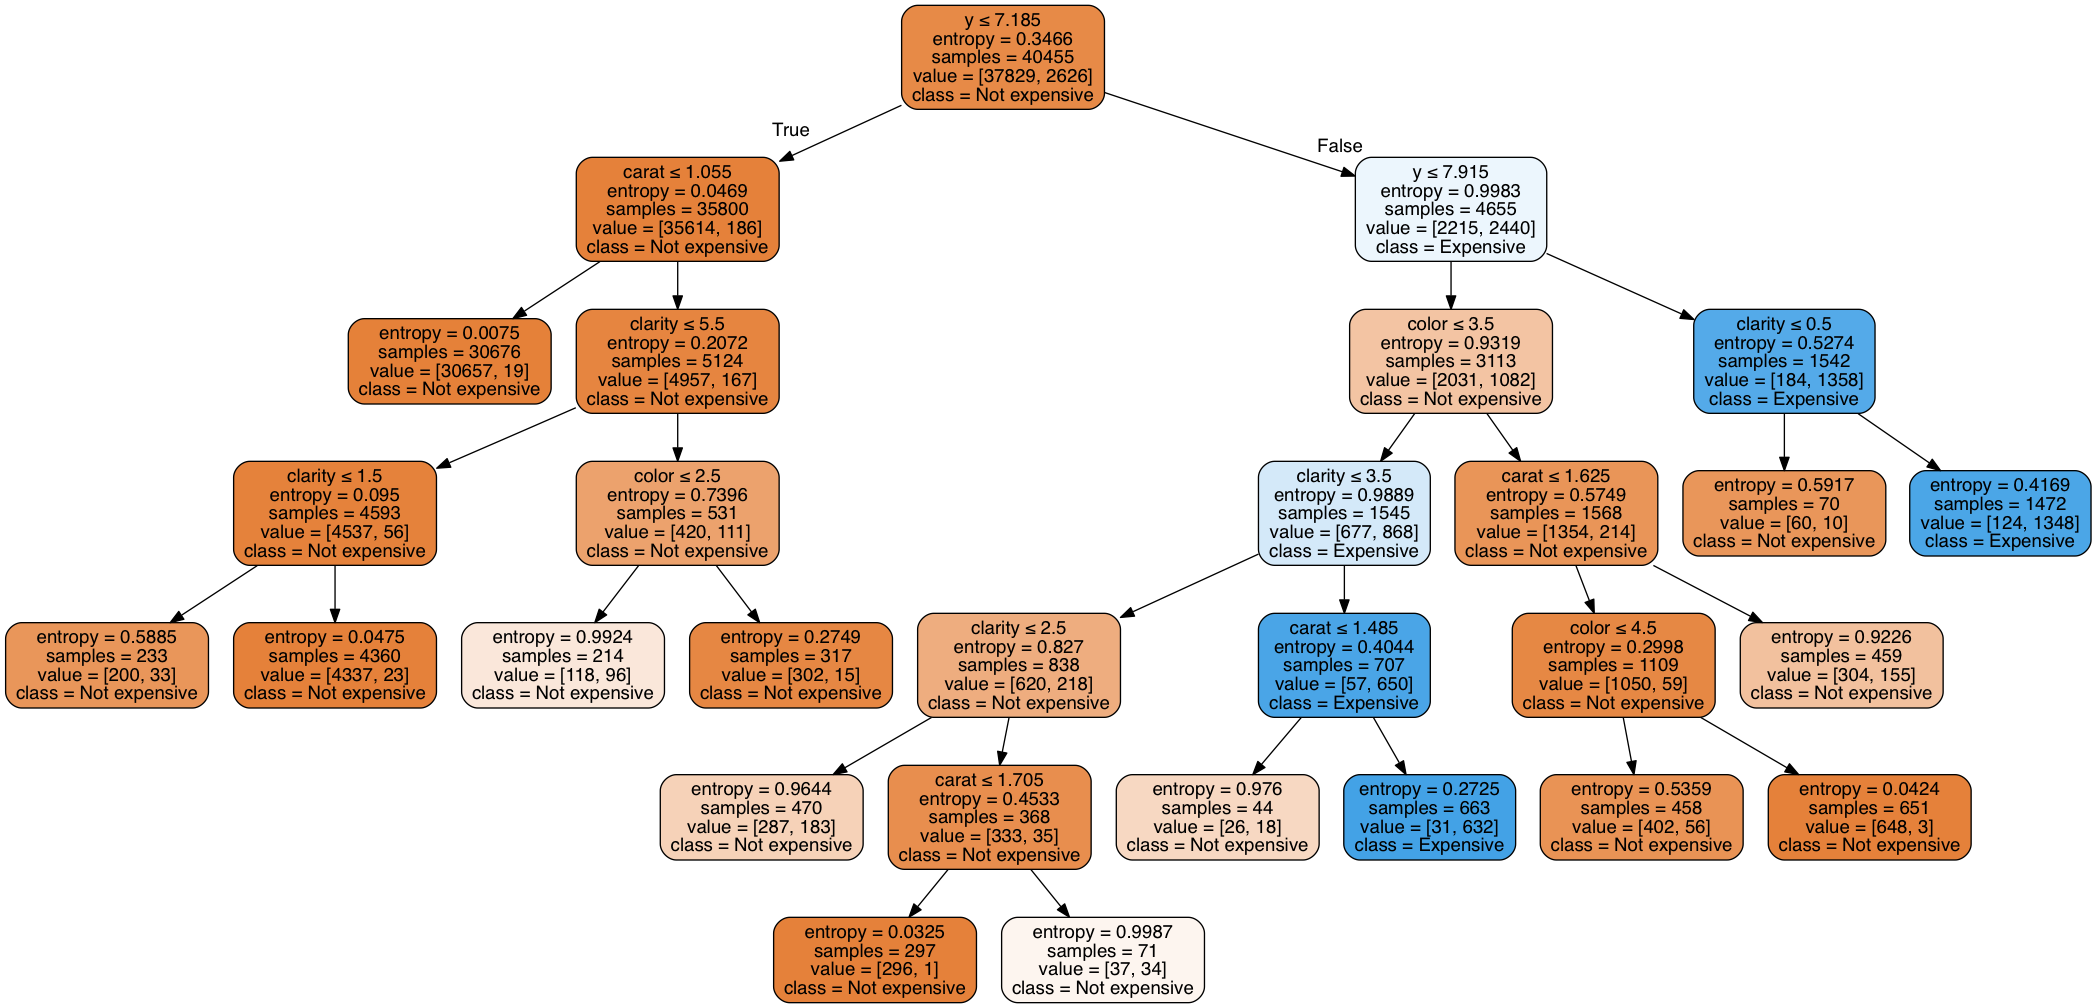

In [117]:
from IPython.display import Image  
Image(graph.create_png())

In [124]:
label_encodings

{'clarity': {0: 'I1',
  1: 'IF',
  2: 'SI1',
  3: 'SI2',
  4: 'VS1',
  5: 'VS2',
  6: 'VVS1',
  7: 'VVS2'},
 'color': {0: 'D', 1: 'E', 2: 'F', 3: 'G', 4: 'H', 5: 'I', 6: 'J'},
 'cut': {0: 'Fair', 1: 'Good', 2: 'Ideal', 3: 'Premium', 4: 'Very Good'}}

### Bagging with decision trees

In [118]:
bagging = BaggingClassifier(
    DecisionTreeClassifier(criterion='entropy', random_state=42, max_leaf_nodes=15), 
    max_samples=0.8, 
    max_features=0.8)
bagging.fit(X_train, y_train)

/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=15, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=0.8,
         max_samples=0.8, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [119]:
accuracy_score(y_test, bagging.predict(X_test))

0.98205413422321097

### Gradient boosting with regression trees

In [120]:
clf = GradientBoostingClassifier(random_state=42, max_leaf_nodes=15)
clf.fit(X_train, y_train)

/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=15,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [121]:
accuracy_score(y_test, clf.predict(X_test))

0.9879866518353726

## Random forests

In [122]:
clf = RandomForestClassifier(criterion='entropy', random_state=42, max_leaf_nodes=15)
clf.fit(X_train, y_train)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=15,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [123]:
accuracy_score(y_test, clf.predict(X_test))

0.98160919540229885